In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; 
sns.axes_style("whitegrid")
sns.set_context("paper")
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

def predictCLFmap(X,clf,h=0.02):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    return Z,xx,yy

In [2]:
pitching = pd.read_csv('Pitching.csv')
pitching.head()
pitching = pitching.dropna()
pitching.head()

pitching.columns
pitching['playerID'].value_counts()
pd.set_option('display.max_columns', None)
pitching=pitching.drop(columns=['teamID'])

pitching.head(1)

class_names = ['inducted', 'not inducted']

In [3]:
pitching_final = pitching.drop(columns = ['yearID', 'lgID'])
pitching_final = pitching_final.groupby(['playerID'])
pitching_final = pitching_final.sum()
pitching_final = pitching_final[pitching_final['stint'] >= 10]
pitching_final = pitching_final.drop(columns = ['ERA', 'BAOpp'])

pitching_final

,stint,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
playerID,,,,,,,,,,,,,,,,,,,,,,,,
aasedo01,13,66,60,448,91,22,5,82,3328,1085,468,89,457,641,45.0,22,7.0,3,4730.0,235,503,50.0,34.0,106.0
abadfe01,11,8,29,384,6,0,0,2,992,309,135,42,116,280,10.0,10,12.0,2,1399.0,97,143,7.0,12.0,25.0
abbotgl01,13,62,83,248,206,37,5,0,3858,1405,627,162,352,484,28.0,18,32.0,5,5508.0,13,707,60.0,39.0,111.0
abbotji01,12,87,108,263,254,31,6,0,5022,1779,791,154,620,888,30.0,53,32.0,11,7211.0,5,880,70.0,47.0,200.0
abbotpa01,13,43,37,162,112,1,0,0,2162,682,394,101,393,496,17.0,37,21.0,0,3187.0,17,421,19.0,22.0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zambrca01,12,132,91,354,302,10,5,0,5877,1709,797,161,898,1637,41.0,58,102.0,5,8389.0,11,879,100.0,44.0,174.0
zambrvi01,11,45,44,187,100,1,0,3,2119,669,364,78,404,529,13.0,46,63.0,5,3187.0,36,399,21.0,36.0,61.0
zieglbr01,17,37,38,739,0,0,0,105,2152,654,219,32,248,479,55.0,7,25.0,1,2947.0,264,251,19.0,20.0,138.0


In [4]:
hallOfFame = pd.read_csv('HallOfFame.csv')
hallOfFame = hallOfFame.drop(columns = ['needed_note'])
hallOfFame = hallOfFame[hallOfFame['category'] == 'Player']
hallOfFame = hallOfFame[hallOfFame['votedBy'] == 'BBWAA']
hallOfFame['threshold'] = hallOfFame['needed'] / hallOfFame['ballots']
hallOfFame['percent'] = hallOfFame['votes'] / hallOfFame['ballots']
hallOfFame.head()

,playerID,yearID,votedBy,ballots,needed,votes,inducted,category,threshold,percent
0,cobbty01,1936,BBWAA,226.0,170.0,222.0,Y,Player,0.752212,0.982301
1,ruthba01,1936,BBWAA,226.0,170.0,215.0,Y,Player,0.752212,0.951327
2,wagneho01,1936,BBWAA,226.0,170.0,215.0,Y,Player,0.752212,0.951327
3,mathech01,1936,BBWAA,226.0,170.0,205.0,Y,Player,0.752212,0.907080
4,johnswa01,1936,BBWAA,226.0,170.0,189.0,Y,Player,0.752212,0.836283


In [5]:
pitchers = pd.merge(hallOfFame, pitching_final, on=["playerID"])
pitchers.head(25)

,playerID,yearID,votedBy,ballots,needed,votes,inducted,category,threshold,percent,stint,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,sadecra01,1983,BBWAA,374.0,281.0,2.0,N,Player,0.751337,0.005348,12,19,16,146,26,4,1,3,1035,355,139,24,133,193,18.0,12,10.0,0,1497.0,36,166,17.0,19.0,30.0
1,holtzke01,1985,BBWAA,395.0,297.0,4.0,N,Player,0.751899,0.010127,11,81,70,221,190,57,14,2,3977,1350,528,104,416,559,23.0,46,23.0,0,5614.0,14,612,47.0,27.0,116.0
2,holtzke01,1986,BBWAA,425.0,319.0,5.0,N,Player,0.750588,0.011765,11,81,70,221,190,57,14,2,3977,1350,528,104,416,559,23.0,46,23.0,0,5614.0,14,612,47.0,27.0,116.0
3,ellisdo01,1985,BBWAA,395.0,297.0,1.0,N,Player,0.751899,0.002532,17,74,71,198,188,37,5,1,3640,1222,503,92,377,550,35.0,26,24.0,6,5166.0,5,588,52.0,45.0,100.0
4,billija01,1986,BBWAA,425.0,319.0,1.0,N,Player,0.750588,0.002353,10,101,69,259,212,49,18,4,4331,1534,647,127,496,614,59.0,51,58.0,3,6174.0,26,723,67.0,38.0,198.0
5,marshmi01,1987,BBWAA,413.0,310.0,6.0,N,Player,0.750605,0.014528,13,71,75,508,5,0,0,134,2828,885,315,49,329,569,25.0,41,20.0,4,3958.0,407,358,95.0,28.0,90.0
6,tiantlu01,1988,BBWAA,427.0,321.0,132.0,N,Player,0.751756,0.309133,10,131,92,280,278,109,21,0,5827,1851,789,193,534,1143,21.0,8,26.0,2,8039.0,1,846,58.0,47.0,119.0
7,tiantlu01,1989,BBWAA,447.0,336.0,47.0,N,Player,0.751678,0.105145,10,131,92,280,278,109,21,0,5827,1851,789,193,534,1143,21.0,8,26.0,2,8039.0,1,846,58.0,47.0,119.0
8,tiantlu01,1990,BBWAA,444.0,333.0,42.0,N,Player,0.750000,0.094595,10,131,92,280,278,109,21,0,5827,1851,789,193,534,1143,21.0,8,26.0,2,8039.0,1,846,58.0,47.0,119.0
9,tiantlu01,1991,BBWAA,443.0,333.0,32.0,N,Player,0.751693,0.072235,10,131,92,280,278,109,21,0,5827,1851,789,193,534,1143,21.0,8,26.0,2,8039.0,1,846,58.0,47.0,119.0


In [6]:
pitchers = pitchers.drop_duplicates(subset=['playerID'], keep='last')
pitchers = pitchers.reset_index(drop=True)
pitchers

,playerID,yearID,votedBy,ballots,needed,votes,inducted,category,threshold,percent,stint,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,sadecra01,1983,BBWAA,374.0,281.0,2.0,N,Player,0.751337,0.005348,12,19,16,146,26,4,1,3,1035,355,139,24,133,193,18.0,12,10.0,0,1497.0,36,166,17.0,19.0,30.0
1,holtzke01,1986,BBWAA,425.0,319.0,5.0,N,Player,0.750588,0.011765,11,81,70,221,190,57,14,2,3977,1350,528,104,416,559,23.0,46,23.0,0,5614.0,14,612,47.0,27.0,116.0
2,ellisdo01,1985,BBWAA,395.0,297.0,1.0,N,Player,0.751899,0.002532,17,74,71,198,188,37,5,1,3640,1222,503,92,377,550,35.0,26,24.0,6,5166.0,5,588,52.0,45.0,100.0
3,billija01,1986,BBWAA,425.0,319.0,1.0,N,Player,0.750588,0.002353,10,101,69,259,212,49,18,4,4331,1534,647,127,496,614,59.0,51,58.0,3,6174.0,26,723,67.0,38.0,198.0
4,marshmi01,1987,BBWAA,413.0,310.0,6.0,N,Player,0.750605,0.014528,13,71,75,508,5,0,0,134,2828,885,315,49,329,569,25.0,41,20.0,4,3958.0,407,358,95.0,28.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,hernali01,2018,BBWAA,422.0,317.0,1.0,N,Player,0.751185,0.002370,27,178,177,519,474,50,9,1,9567,3525,1572,362,1066,1976,86.0,41,78.0,13,13816.0,17,1686,174.0,118.0,299.0
175,isrinja01,2018,BBWAA,422.0,317.0,0.0,N,Player,0.751185,0.000000,18,51,55,724,52,3,1,300,3023,901,408,85,437,830,43.0,53,34.0,2,4322.0,499,450,35.0,32.0,81.0
176,lidgebr01,2018,BBWAA,422.0,317.0,0.0,N,Player,0.751185,0.000000,11,26,32,603,1,0,0,225,1810,492,237,57,287,799,41.0,46,34.0,3,2589.0,368,257,32.0,11.0,28.0
177,millwke01,2018,BBWAA,422.0,317.0,0.0,N,Player,0.751185,0.000000,16,169,152,451,443,22,6,0,8161,2770,1243,296,843,2083,46.0,67,74.0,4,11616.0,3,1357,105.0,53.0,211.0


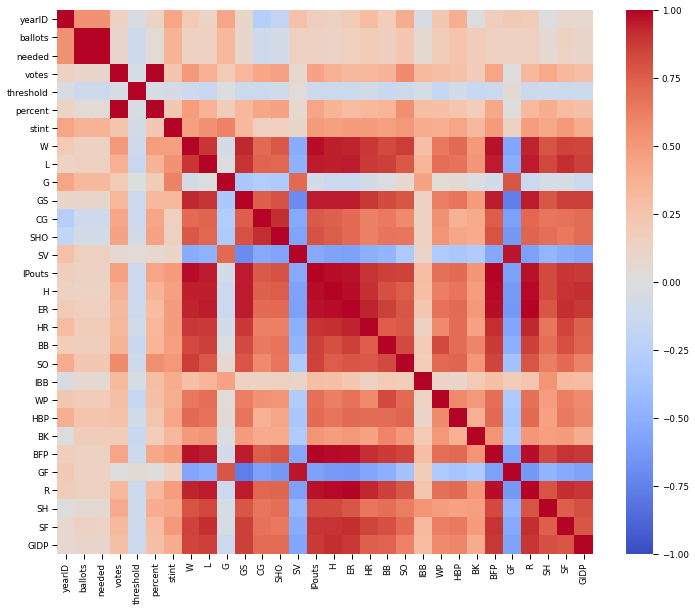

In [7]:
plt.figure(figsize=(12,10))  # on this line I just set the size of figure to 12 by 10.
p=sns.heatmap(pitchers.corr(), annot=False, vmin=-1, vmax=1,cmap ="coolwarm"); 

In [8]:
pitchers['inducted'].value_counts().to_frame()

,inducted
N,160
Y,19


In [9]:
y = pitchers['inducted']
le = LabelEncoder()
le.fit(y)
classes = le.classes_
y_enc=le.transform(y)
pitchers['inducted_enc'] = le.transform(y) #now 1=M; 0=B

pitchers = pitchers.drop(['ballots', 'needed', 'votes', 'threshold', 'percent', 'playerID', 'yearID', 'votedBy', 'category', 'inducted'], axis=1)
pitchers.head()

,stint,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,inducted_enc
0,12,19,16,146,26,4,1,3,1035,355,139,24,133,193,18.0,12,10.0,0,1497.0,36,166,17.0,19.0,30.0,0
1,11,81,70,221,190,57,14,2,3977,1350,528,104,416,559,23.0,46,23.0,0,5614.0,14,612,47.0,27.0,116.0,0
2,17,74,71,198,188,37,5,1,3640,1222,503,92,377,550,35.0,26,24.0,6,5166.0,5,588,52.0,45.0,100.0,0
3,10,101,69,259,212,49,18,4,4331,1534,647,127,496,614,59.0,51,58.0,3,6174.0,26,723,67.0,38.0,198.0,0
4,13,71,75,508,5,0,0,134,2828,885,315,49,329,569,25.0,41,20.0,4,3958.0,407,358,95.0,28.0,90.0,0


In [10]:
pitchers_class_0    = pitchers[pitchers['inducted_enc'] == 1] #class with fewer samples
pitchers_class_1    = pitchers[pitchers['inducted_enc'] == 0] #class with more samples
count_class_0 = len(pitchers_class_0)
count_class_1 = len(pitchers_class_1)

print(count_class_0)
print(count_class_1)

19
160


In [11]:
Y = pitchers['inducted_enc']
X = pitchers.drop(['inducted_enc'], axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,Y, stratify = y, test_size=.3, random_state=325)

In [12]:
smote = SMOTE(sampling_strategy='minority', k_neighbors = 2)
X_oversample, y_oversample = smote.fit_resample(X_train, y_train)

In [13]:
clf = MultinomialNB()
clf.fit(X_oversample, y_oversample);

Accuracy : 87.04 %


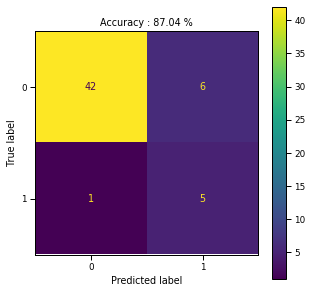

              precision    recall  f1-score   support

           0       0.98      0.88      0.92        48
           1       0.45      0.83      0.59         6

    accuracy                           0.87        54
   macro avg       0.72      0.85      0.76        54
weighted avg       0.92      0.87      0.89        54



In [14]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
predicted = clf.predict(X_test)
print("Accuracy : {} %".format(round(acc*100, 2)))

fig,ax = plt.subplots(1,1,figsize=(5, 5))
cmd=ConfusionMatrixDisplay(cm) 
cmd.plot(ax=ax)
plt.title("Accuracy : {} %".format(round(acc*100, 2)))
plt.show()

print(classification_report(y_test, clf.predict(X_test)))

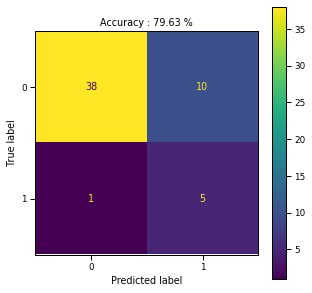

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.09802
Feature: 6, Score: 0.47531
Feature: 7, Score: 0.42667
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
              precision    recall  f1-score   support

           0       0.97      0.79      0.87        48
           1       0.33      0.83      0.48         6

    accuracy                           0.80        54
   macro avg       0.65      0.81      0.67        54
weighted avg       0.90      0.80      0.83        54



In [15]:
clf = DecisionTreeClassifier(max_depth = 2, random_state = 0)
clf.fit(X_oversample, y_oversample)
predicted = clf.predict(X_test)
acc = accuracy_score(y_test, predicted)
cm = confusion_matrix(y_test, predicted)

fig,ax = plt.subplots(1,1,figsize=(5, 5))
cmd=ConfusionMatrixDisplay(cm) 
cmd.plot(ax=ax)
plt.title("Accuracy : {} %".format(round(acc*100, 2)))
plt.show()

importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
print(classification_report(y_test, clf.predict(X_test)))

0 = not inducted 
1 = inducted 

Most important features Strike outs, shutouts,and complete games with with stikeouts having the highest and shutouts being the second highest. This model is also good at predicting true players in the hall of fame, it them model predicts they are in the hall of fame then it is almost certain they are inducted

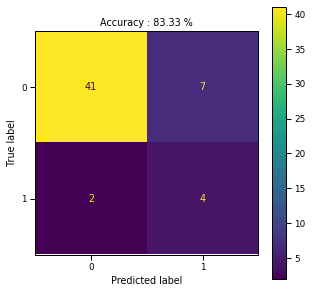

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.01767
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.06240
Feature: 6, Score: 0.30259
Feature: 7, Score: 0.27163
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.11768
Feature: 14, Score: 0.17636
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.05169
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
              precision    recall  f1-score   support

           0       0.95      0.85      0.90        48
           1       0.36      0.67      0.47         6

    accuracy                           0.83        54
   macro avg       0.66      0.76      0.69        54
weighted avg       0.89      0.83      0.85        54



In [16]:
clf = DecisionTreeClassifier(max_depth = 4, random_state = 0)
clf.fit(X_oversample, y_oversample)
predicted = clf.predict(X_test)
acc = accuracy_score(y_test, predicted)
cm = confusion_matrix(y_test, predicted)

fig,ax = plt.subplots(1,1,figsize=(5, 5))
cmd=ConfusionMatrixDisplay(cm) 
cmd.plot(ax=ax)
plt.title("Accuracy : {} %".format(round(acc*100, 2)))
plt.show()

importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
print(classification_report(y_test, clf.predict(X_test)))

This in my mind would be overfitting the data with a depth of 4, when the model has this high of an accuracy and only misclassifies two of the players, it would not be good for when it is being used on new data. Therefore I think the model with the max depth of 2 works the best

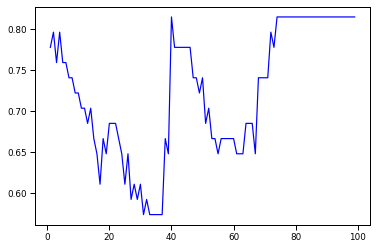

Parameter k=40 gave the maximum accuracy: 0.8148148148148148


In [17]:
def get_accuracy(k):
    # Build the k-NN classifier
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_oversample, y_oversample)
    # Compute predictions
    y_predict = clf.predict(X_test)
    return accuracy_score(y_test, y_predict)

k_values = list(range(1, 100))
acc_values = [get_accuracy(k) for k in k_values]
plt.plot(k_values, acc_values, color='blue')
plt.show()
best_index = np.argmax(acc_values)
print("Parameter k={} gave the maximum accuracy: {}".format(k_values[best_index], acc_values[best_index]))

kNN Classifier Model with Testing Data:
0.7407407407407407


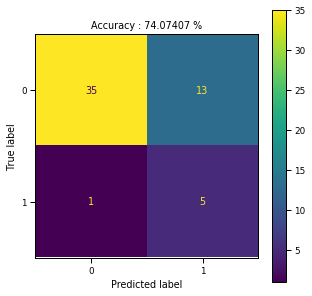

              precision    recall  f1-score   support

           0       0.95      0.85      0.90        48
           1       0.36      0.67      0.47         6

    accuracy                           0.83        54
   macro avg       0.66      0.76      0.69        54
weighted avg       0.89      0.83      0.85        54



In [18]:
k = 68
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_oversample, y_oversample)
predicted = model.predict(X_test)
acc = accuracy_score(y_test, predicted)
print("kNN Classifier Model with Testing Data:")
y_predict = model.predict(X_test)
cm = confusion_matrix(y_test, y_predict)
print(accuracy_score(y_test, y_predict))

fig,ax = plt.subplots(1,1,figsize=(5, 5))
cmd=ConfusionMatrixDisplay(cm) 
cmd.plot(ax=ax)
plt.title("Accuracy : {} %".format(round(acc*100, 5)))
plt.show()

print(classification_report(y_test, clf.predict(X_test)))